# 03 — Model Training & Evaluation

Goal:
- Train baseline model
- Train stronger model
- Evaluate (F1, ROC-AUC, confusion matrix)
- Save best model pipeline to artifacts/models


In [1]:
import sys
print(sys.executable)

import sklearn
import seaborn as sns
import matplotlib.pyplot as plt

print("sklearn:", sklearn.__version__)
print("seaborn:", sns.__version__)


c:\Users\user\AppData\Local\Programs\Python\Python310\python.exe
sklearn: 1.6.1
seaborn: 0.13.2


In [2]:
import os, joblib
import numpy as np
import pandas as pd

from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve
)
import matplotlib.pyplot as plt
import seaborn as sns

DATA_OBJ = "../artifacts/data/splits_and_preprocess.joblib"
assert os.path.exists(DATA_OBJ), "Run notebook 02 first."

X_train, X_test, y_train, y_test, preprocess = joblib.load(DATA_OBJ)


In [3]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

models = {
    "logreg": LogisticRegression(max_iter=2000),
    "rf": RandomForestClassifier(
        n_estimators=300, random_state=42, class_weight="balanced", n_jobs=-1
    )
}

trained = {}
for name, model in models.items():
    pipe = Pipeline(steps=[
        ("preprocess", preprocess),
        ("model", model)
    ])
    pipe.fit(X_train, y_train)
    trained[name] = pipe
    print("Trained:", name)


Trained: logreg
Trained: rf



=== logreg ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1035
           1       1.00      1.00      1.00       374

    accuracy                           1.00      1409
   macro avg       1.00      1.00      1.00      1409
weighted avg       1.00      1.00      1.00      1409



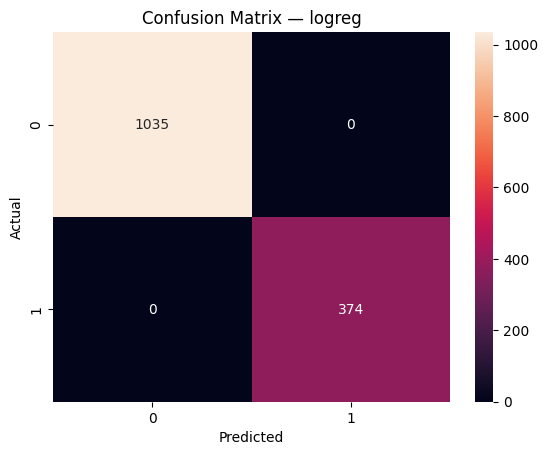

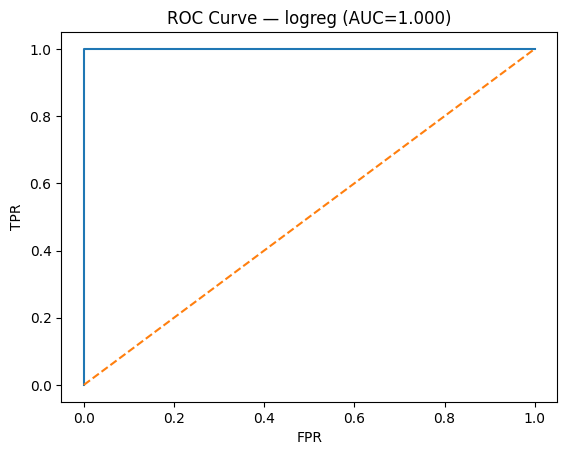


=== rf ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1035
           1       1.00      1.00      1.00       374

    accuracy                           1.00      1409
   macro avg       1.00      1.00      1.00      1409
weighted avg       1.00      1.00      1.00      1409



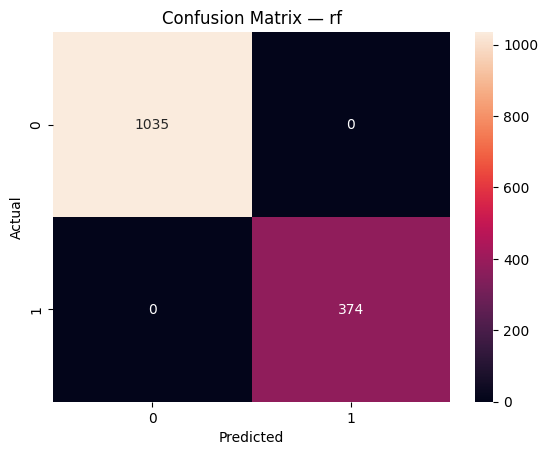

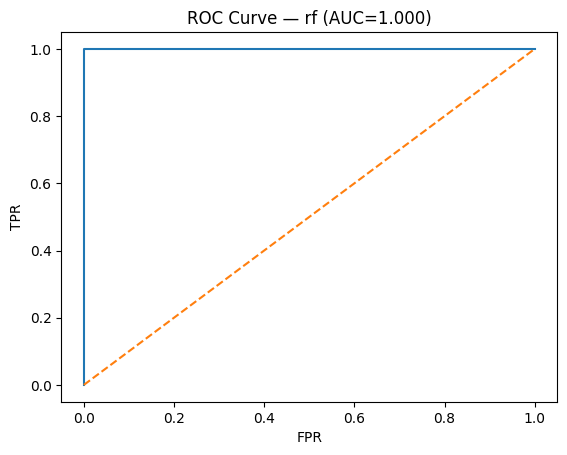

{'logreg': 1.0, 'rf': 1.0}

In [4]:
def evaluate(pipe, X_test, y_test, title="model"):
    y_pred = pipe.predict(X_test)

    # predict_proba may not exist for some models
    if hasattr(pipe, "predict_proba"):
        y_proba = pipe.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_proba)
    else:
        y_proba = None
        auc = None

    print(f"\n=== {title} ===")
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)

    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title(f"Confusion Matrix — {title}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    if y_proba is not None:
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.figure()
        plt.plot(fpr, tpr)
        plt.plot([0,1],[0,1], linestyle="--")
        plt.title(f"ROC Curve — {title} (AUC={auc:.3f})")
        plt.xlabel("FPR")
        plt.ylabel("TPR")
        plt.show()

    return auc

scores = {}
for name, pipe in trained.items():
    scores[name] = evaluate(pipe, X_test, y_test, title=name)

scores


In [5]:
best_name = max([k for k in scores if scores[k] is not None], key=lambda k: scores[k], default="logreg")
best_model = trained[best_name]

os.makedirs("../artifacts/models", exist_ok=True)
out_path = f"../artifacts/models/churn_model_{best_name}.joblib"
joblib.dump(best_model, out_path)
print("Saved best model:", out_path)


Saved best model: ../artifacts/models/churn_model_logreg.joblib


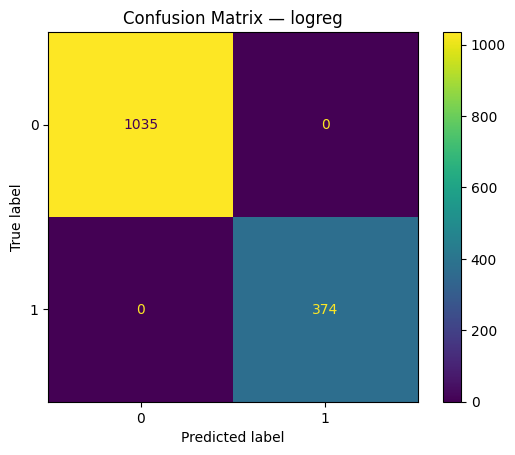

Saved: ../artifacts/figures/confusion_matrix.png


In [6]:

import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

y_pred = best_model.predict(X_test)
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title(f"Confusion Matrix — {best_name}")
os.makedirs("../artifacts/figures", exist_ok=True)
plt.savefig("../artifacts/figures/confusion_matrix.png", bbox_inches="tight", dpi=200)
plt.show()

print("Saved: ../artifacts/figures/confusion_matrix.png")
